# CP Decomposition

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorly as tl
from tensorly.decomposition import parafac
import tlviz
import warnings
from kneed import KneeLocator

## Import tensors

In [2]:
# real data
tensor_70 = np.load('real_data/tensor_70.npy')
tensor_100 = np.load('real_data/tensor_100.npy')
tensor_200 = np.load('real_data/tensor_200.npy')
tensor_300 = np.load('real_data/tensor_300.npy')
# simulated data
tensor_1 = np.load('simulated_data/tensor_1.npy')
tensor_2 = np.load('simulated_data/tensor_2.npy')

## Number of components

In [3]:
# we create a list with the tensors for more efficient coding
tensors_real = [tensor_70, tensor_100, tensor_200, tensor_300]
tensor_real_names = ['70', '100', '200', '300']
tensors_sim = [tensor_1, tensor_2]
tensor_sim_names = ['1', '2']

### CORCONDIA

In [13]:
def visualization_corcondia(tensors, tensor_names):
    val = len(tensors)
    fig, axes = plt.subplots(1, val, figsize=(val*3, 3))
    axes = axes.flatten()
    
    for i, (tensor, name) in enumerate(zip(tensors, tensor_names)):
        plt.sca(axes[i])
    
        models = {}
        for rank in [1, 2, 3, 4, 5, 6, 7]:
            models[rank] = parafac(tensor, rank=rank)
        
        ax = tlviz.visualisation.scree_plot(models, tensor, metric="Core consistency")
        ax.set_ylim(0, 105)
        ax.set_title(f"tensor_{name}")
        ax.set_xlabel("Num of Comps.")

        ax.set_xticks([1, 2, 3, 4, 5, 6, 7])

        corcondia_values = [ax.lines[0].get_ydata()[i] for i in [0, 1, 2, 3, 4, 5, 6]]

        first = round(corcondia_values[0], 2)
        second = round(corcondia_values[1], 2)
        third = round(corcondia_values[2], 2)
        forth = round(corcondia_values[3], 2)

        print(f"Corcondia values for tensor_{name}: {first}, {second}, {third}, {forth}")
    
    plt.tight_layout()
    plt.show()

Corcondia values for tensor_70: 100.0, 100.0, -11216.41, -38269.13
Corcondia values for tensor_100: 100.0, 100.0, 4.59, -218.82
Corcondia values for tensor_200: 100.0, 100.0, -1331.23, -43120.24
Corcondia values for tensor_300: 100.0, 100.0, 65.93, -312.17


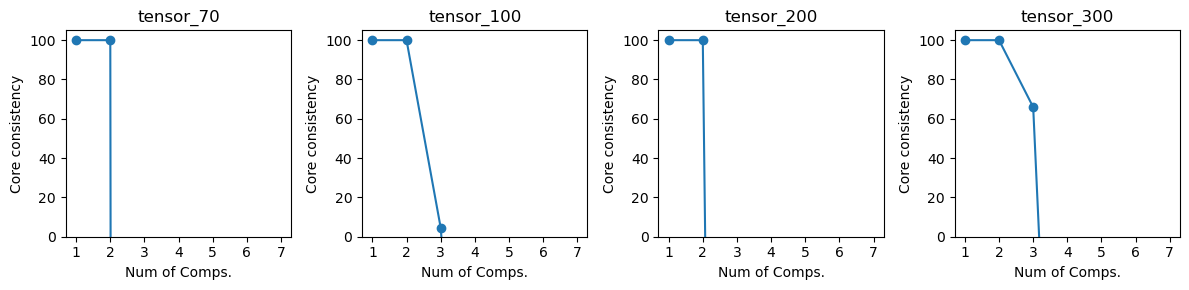

In [14]:
#tensors_real
visualization_corcondia(tensors_real, tensor_real_names)

Corcondia values for tensor_1: 100.0, 100.0, 96.94, 89.98
Corcondia values for tensor_2: 100.0, 100.0, -391.49, -297.67


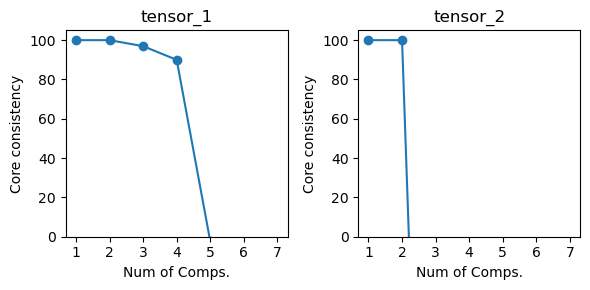

In [15]:
#tensors_sim
visualization_corcondia(tensors_sim, tensor_sim_names)

### Reconstruction error

In [19]:
def error(original, res):
    res = res.to_tensor() 
    assert original.shape == res.shape
    return np.sum((original - res)**2) / np.sum(original**2)

In [17]:
def visualization_error(tensors, tensor_names):
    val = len(tensors)
    fig, axes = plt.subplots(1, val, figsize=(val*3, 3))
    axes = axes.flatten() 

    warnings.simplefilter("ignore", UserWarning)
    
    for ax, tensor, name in zip(axes, tensors, tensor_names):
        errors = pd.DataFrame(columns=["Num of Comps.", "Reconstruction error"])
        for rr in np.arange(1, 8):
            model_ = parafac(tensor, rank=rr)
            err = error(tensor, model_)
            errors.loc[len(errors)] = [rr, err]
        print(errors)

        kneedle = KneeLocator(errors["Num of Comps."], errors["Reconstruction error"], curve="convex", direction="decreasing")
        elbow = kneedle.elbow
        
        sns.pointplot(data=errors, x="Num of Comps.", y="Reconstruction error", ax=ax)
        ax.set_title(f"tensor_{name}")
        ax.set_xticklabels(errors["Num of Comps."].astype(int))

        if elbow:
            ax.axvline(elbow - 1, color="red", linestyle="--")
    
    plt.tight_layout()
    plt.show()

   Num of Comps.  Reconstruction error
0            1.0              0.605202
1            2.0              0.415393
2            3.0              0.332645
3            4.0              0.273316
4            5.0              0.234900
5            6.0              0.196080
6            7.0              0.172923
   Num of Comps.  Reconstruction error
0            1.0              0.627010
1            2.0              0.482015
2            3.0              0.395653
3            4.0              0.330690
4            5.0              0.262931
5            6.0              0.211982
6            7.0              0.183906
   Num of Comps.  Reconstruction error
0            1.0              0.637625
1            2.0              0.312233
2            3.0              0.245136
3            4.0              0.213817
4            5.0              0.168726
5            6.0              0.152258
6            7.0              0.121736
   Num of Comps.  Reconstruction error
0            1.0         

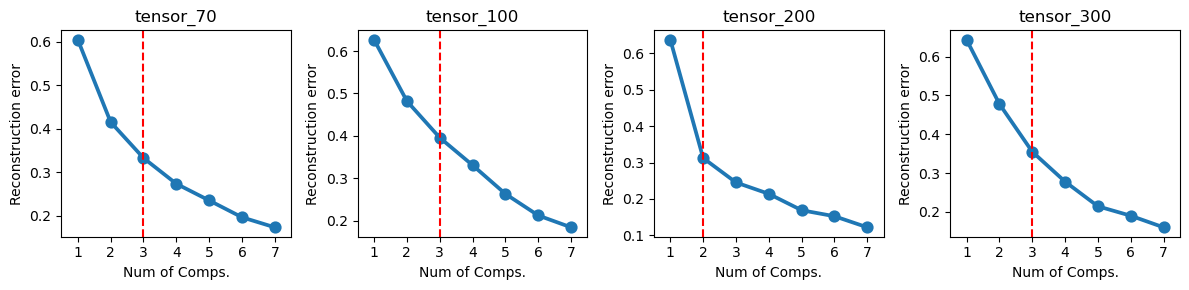

In [20]:
# tensors_real
visualization_error(tensors_real, tensor_real_names)

   Num of Comps.  Reconstruction error
0            1.0              0.627355
1            2.0              0.410671
2            3.0              0.290703
3            4.0              0.281093
4            5.0              0.271769
5            6.0              0.263570
6            7.0              0.255735
   Num of Comps.  Reconstruction error
0            1.0              0.572807
1            2.0              0.431971
2            3.0              0.300474
3            4.0              0.291536
4            5.0              0.283151
5            6.0              0.275065
6            7.0              0.267140


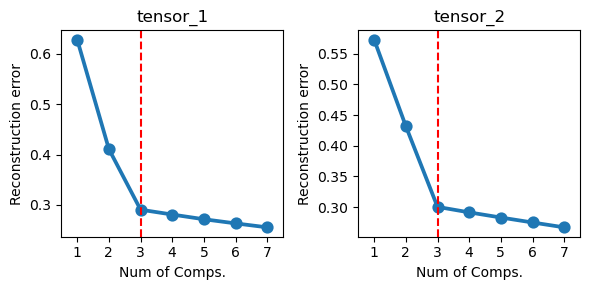

In [21]:
visualization_error(tensors_sim, tensor_sim_names)

## Decompositions

In [22]:
def decomposition_visualization(factors, patients):
    factor_labels = ["T Cells", "Days", "Patients"]
    x_labels = [range(f.shape[0]) for f in factors]
    
    num_components = factors[0].shape[1]
    
    fig, axes = plt.subplots(num_components, 3, figsize=(15, 4 * num_components))
    
    for component in range(num_components):
        for dim in range(3):
            ax = axes[component, dim]
            if dim == 0 or dim == 2:
                ax.bar(x_labels[dim], factors[dim][:, component], color='royalblue', alpha=0.8)
            else:
                ax.plot(x_labels[dim], factors[dim][:, component], marker='o', linestyle='-')
            ax.set_title(f"Component {component+1} - {factor_labels[dim]}")
            ax.set_xlabel(factor_labels[dim])
            ax.set_ylabel("Weight")
            if dim == 1:
                time_labels = [t * 10 for t in x_labels[dim]]
                ax.set_xticks(x_labels[dim])
                ax.set_xticklabels(time_labels)
                if len(time_labels) > 29:
                    step = 6
                elif len(time_labels) > 19:
                    step = 4
                elif len(time_labels) > 9:
                    step = 2 
                else:
                    step = 1 
                
                ax.set_xticks(x_labels[dim][::step])  # Reduce number of ticks
                ax.set_xticklabels(time_labels[::step]) 
            if dim == 2:
                ax.set_xticks(range(len(patients)))
                ax.set_xticklabels(patients, rotation=45, ha="right")
    
    plt.tight_layout()
    plt.show()

### tensor_70

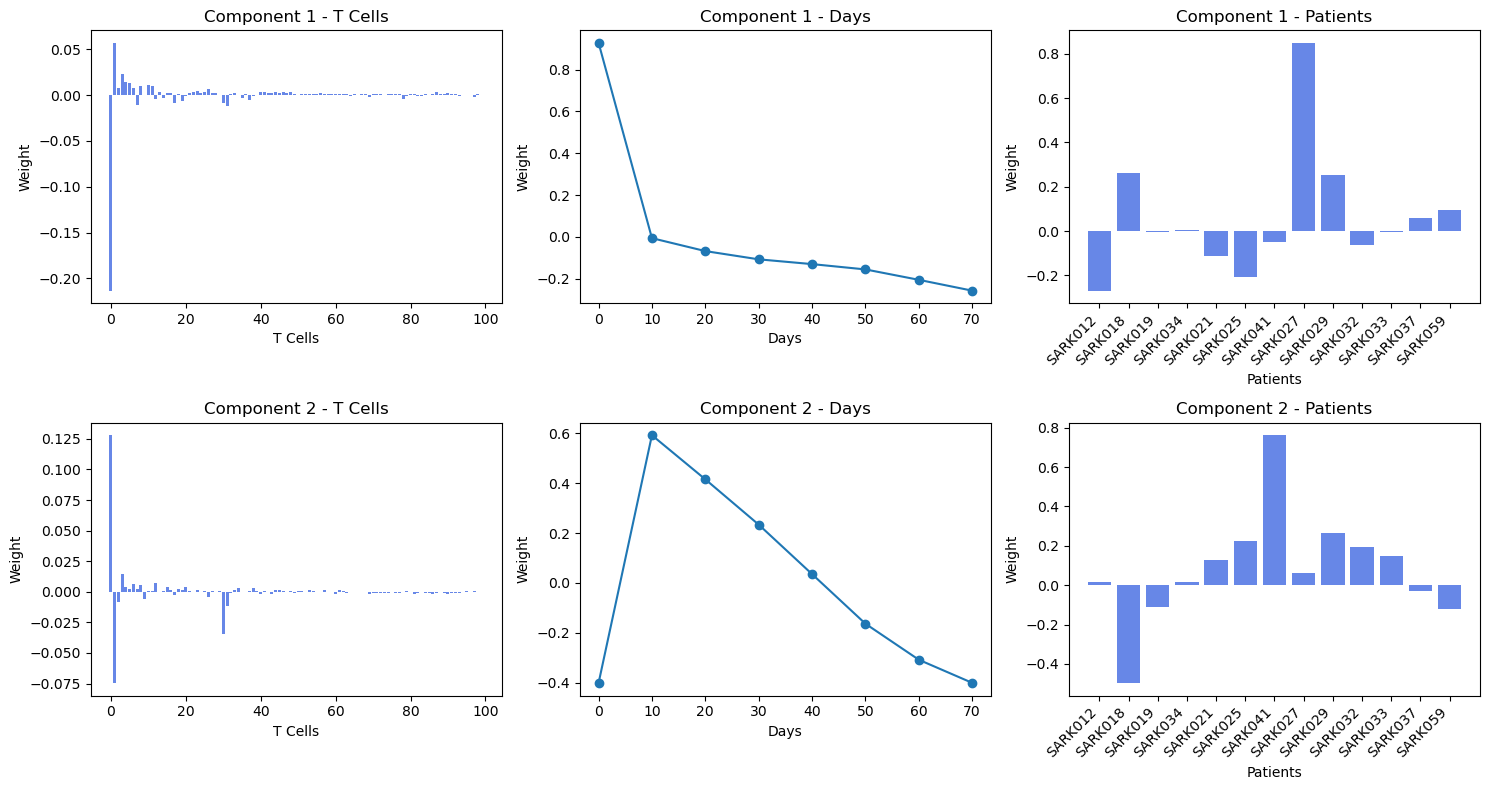

In [23]:
tensor_70 = tl.tensor(tensor_70)
weights_70, factors_70 = parafac(tensor_70, rank=2)
patients = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK041', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK059']
decomposition_visualization(factors_70, patients)

### tensor_100

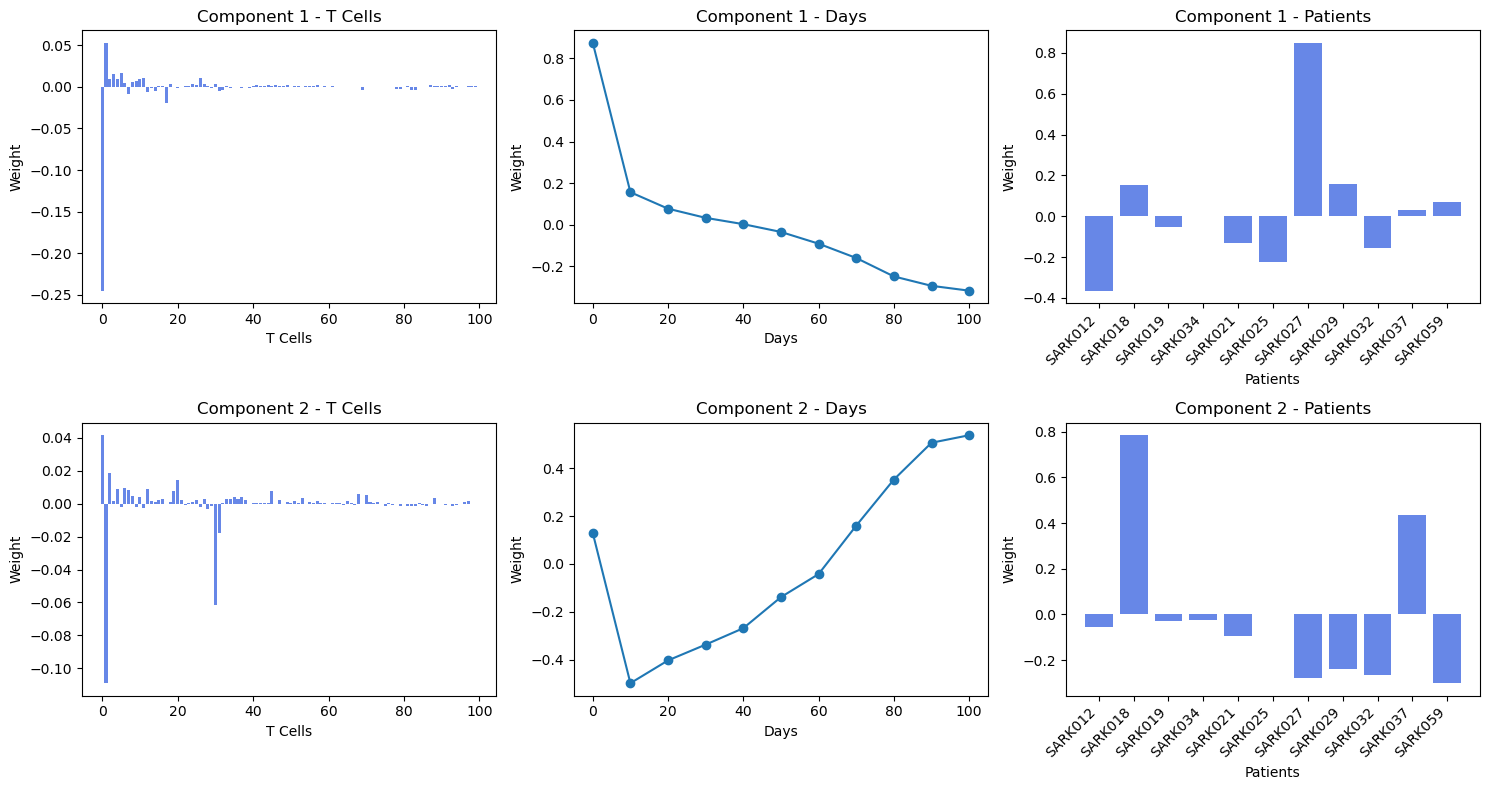

In [24]:
tensor_100 = tl.tensor(tensor_100)
weights_100, factors_100 = parafac(tensor_100, rank=2)
patients = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK027', 'SARK029', 'SARK032', 'SARK037', 'SARK059']
decomposition_visualization(factors_100, patients)

### tensor_200

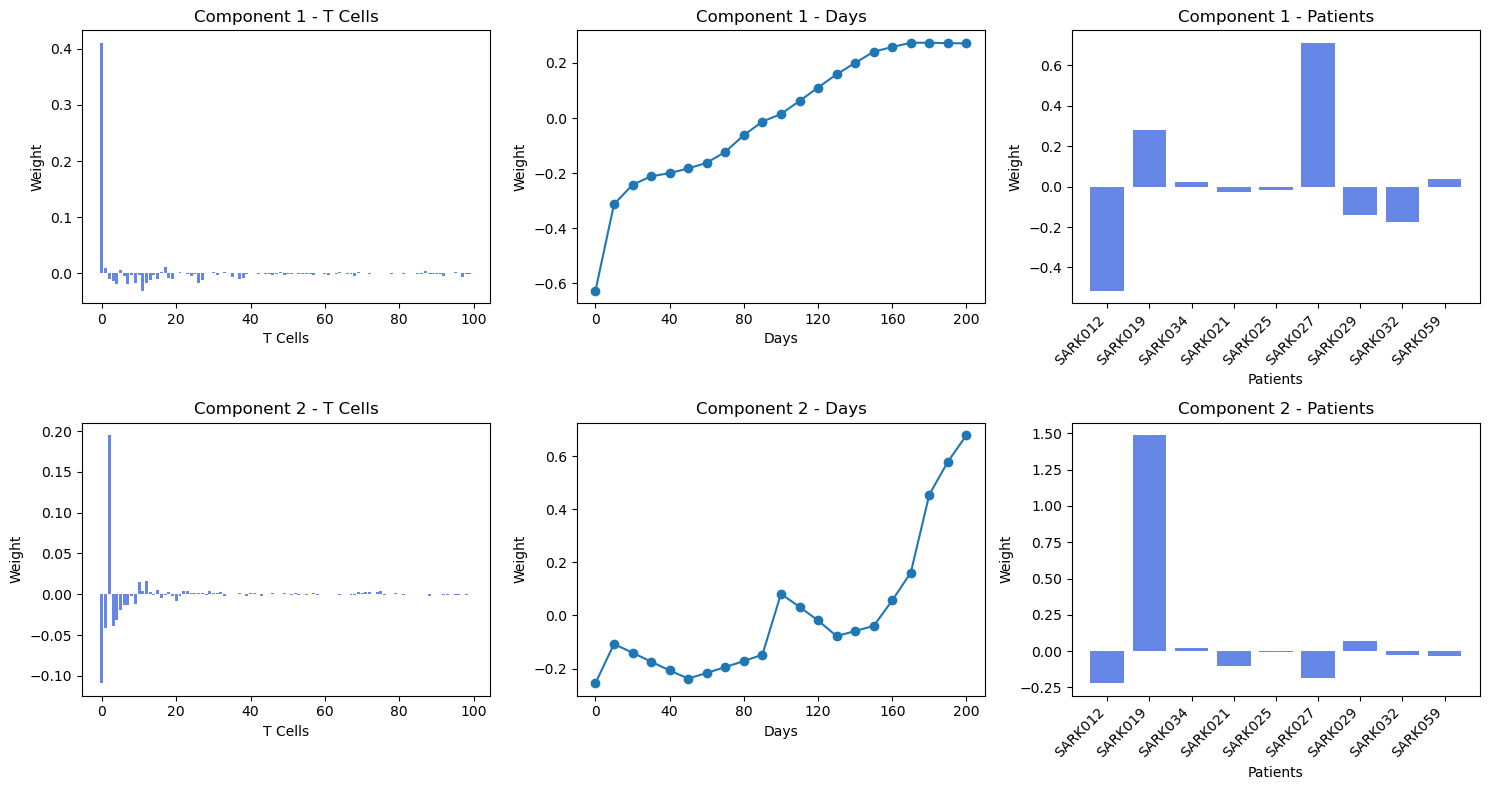

In [25]:
tensor_200 = tl.tensor(tensor_200)
weights_200, factors_200 = parafac(tensor_200, rank=2)
patients = ['SARK012', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
            'SARK027', 'SARK029', 'SARK032', 'SARK059']
decomposition_visualization(factors_200, patients)

### tensor_300

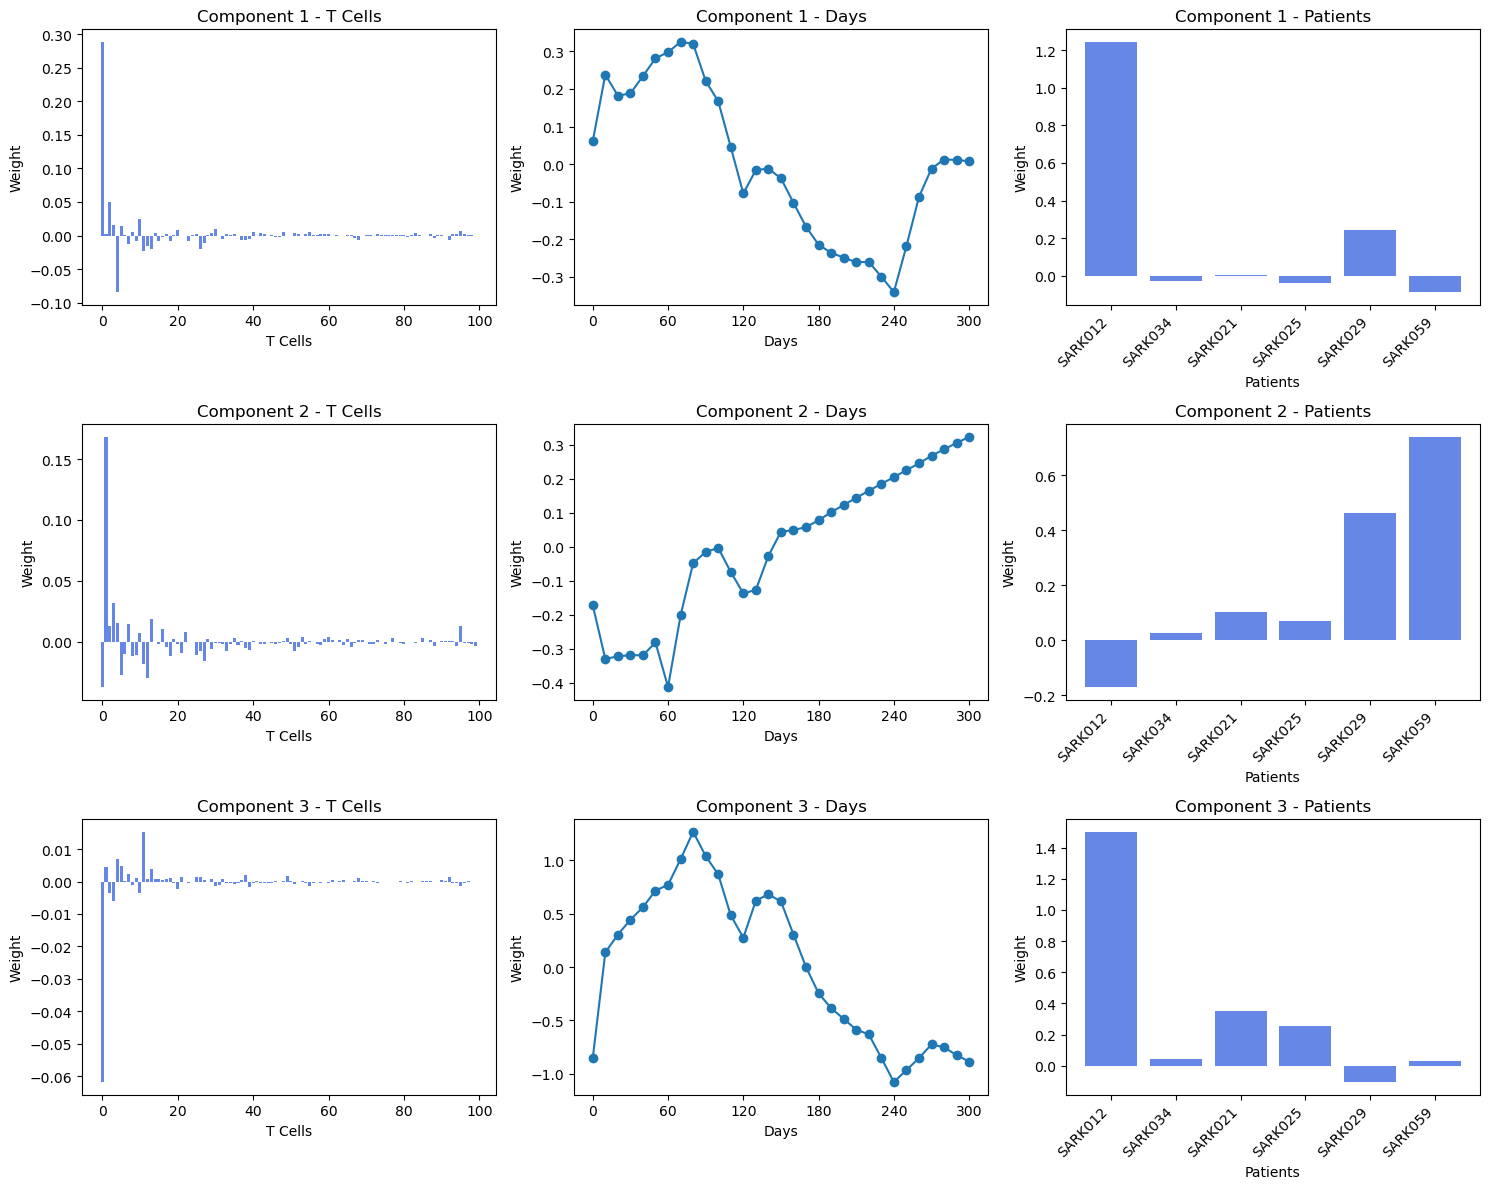

In [26]:
tensor_300 = tl.tensor(tensor_300)
weights_300, factors_300 = parafac(tensor_300, rank=3)
patients = ['SARK012', 'SARK034', 'SARK021', 'SARK025', 'SARK029', 'SARK059']
decomposition_visualization(factors_300, patients)

### tensor_1

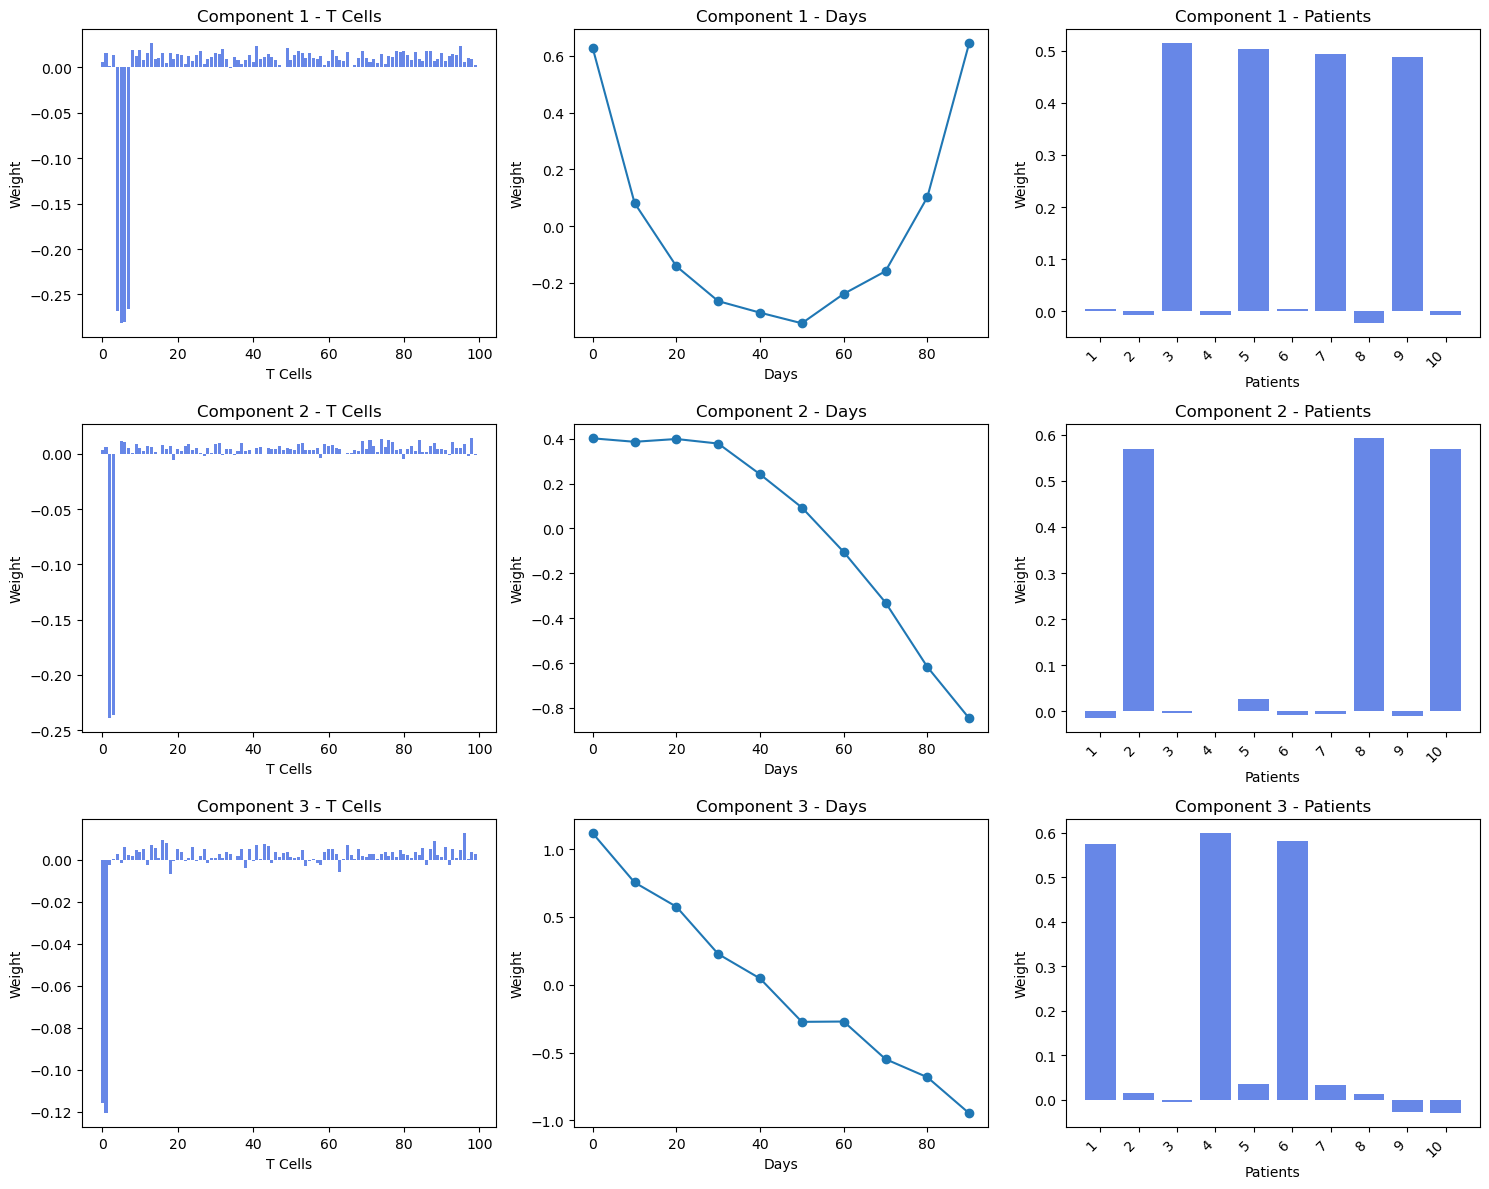

In [27]:
tensor_1 = tl.tensor(tensor_1)
weights_1, factors_1 = parafac(tensor_1, rank=3)
patients = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
decomposition_visualization(factors_1, patients)

### tensor_2

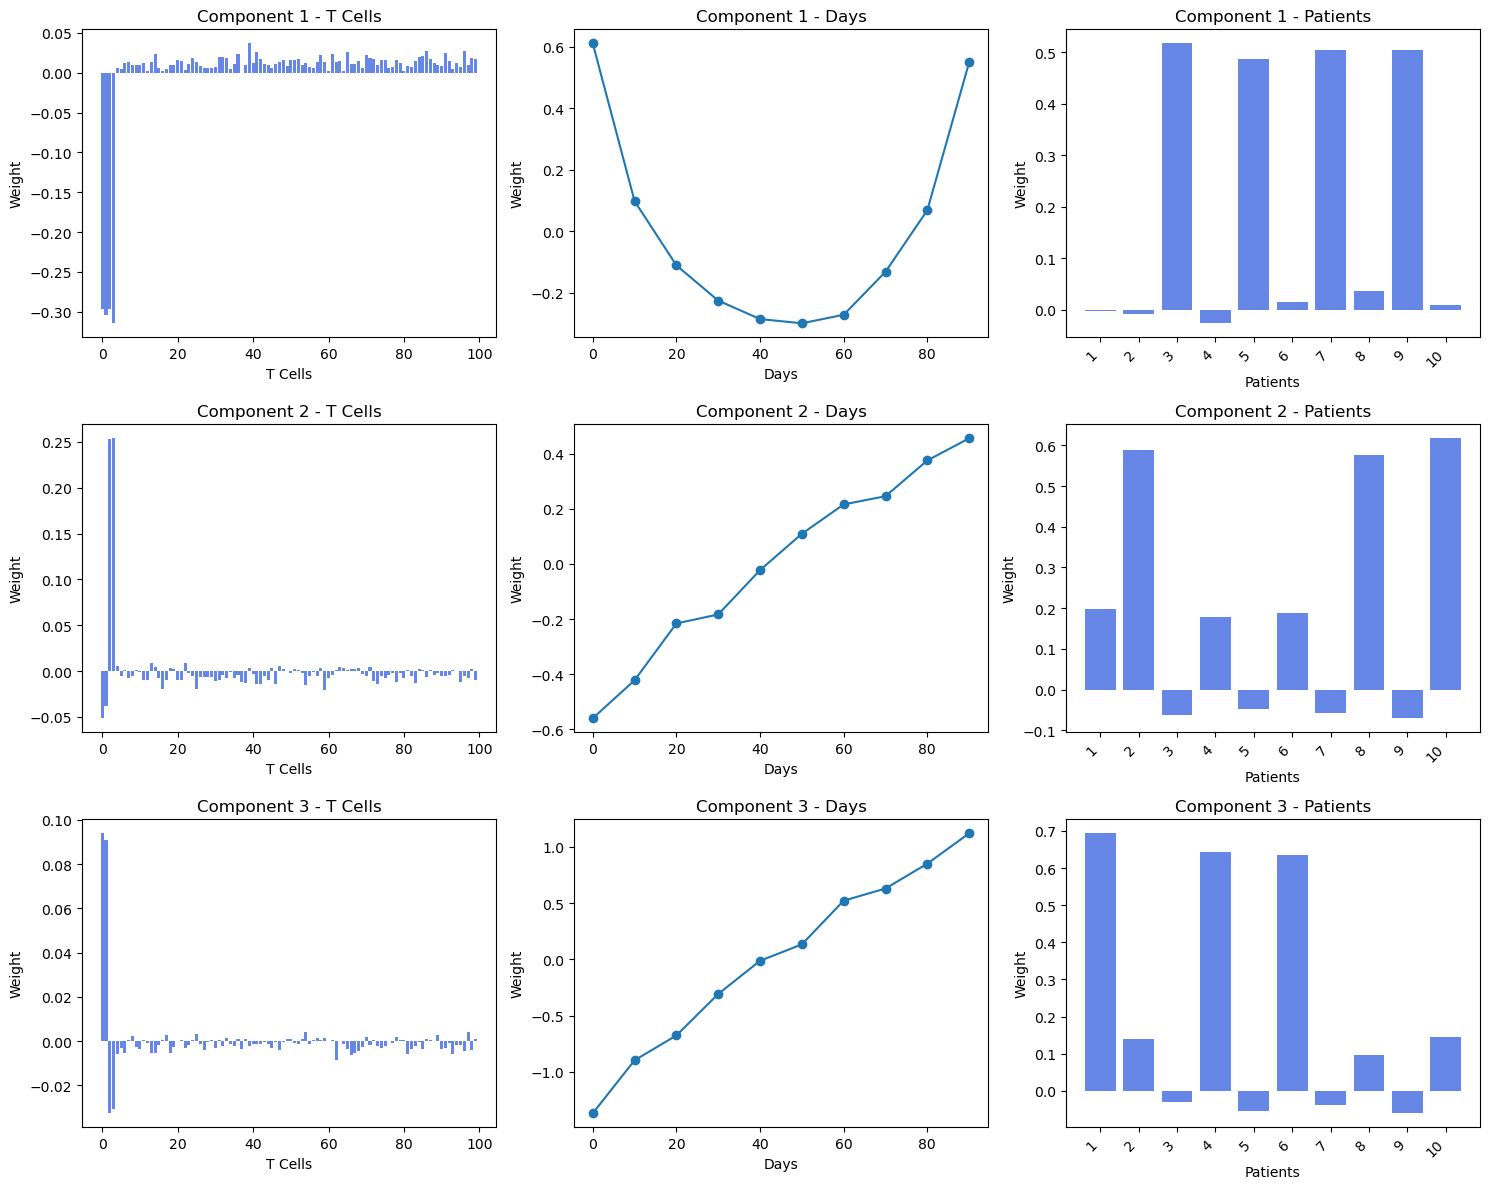

In [28]:
tensor_2 = tl.tensor(tensor_2)
weights_2, factors_2 = parafac(tensor_2, rank=3)
patients = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
decomposition_visualization(factors_2, patients)